In [2]:
import torch
import matplotlib.pyplot as plt
from torch import distributions
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib as mpl
mpl.rcParams['font.size'] = 14

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from network import ClassifierNN,load_model_info
from density_utils import draw_density_ratio, refine_sample, refine_sample2, draw_density_ratio2

from utils import load_item, show_grasp
from dataset import ToyGraspDataset

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# from sklearn.datasets import make_moons, make_circles, make_classification
# from sklearn.neural_network import MLPClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

# names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
#          "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
#          "Naive Bayes", "QDA"]

# classifiers = [
#     KNeighborsClassifier(3),
#     SVC(kernel="linear", C=0.025),
#     SVC(gamma=2, C=1),
#     GaussianProcessClassifier(1.0 * RBF(1.0)),
#     DecisionTreeClassifier(max_depth=5),
#     RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
#     MLPClassifier(alpha=1),
#     AdaBoostClassifier(),
#     GaussianNB(),
#     QuadraticDiscriminantAnalysis()]

# X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
#                            random_state=1, n_clusters_per_class=1)
# rng = np.random.RandomState(2)
# X += 2 * rng.uniform(size=X.shape)
# linearly_separable = (X, y)



In [4]:
# USING 2D FORK DATA ===============================
train_dataset = ToyGraspDataset(root='data', name='train_data', size=1000, is_pos_label=True, device=device, dataset='sim2real')
# test_dataset = ToyGraspDataset(root='data', name='test_data', size=50, is_pos_label=True, device=device, dataset='sim2real')
# test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)

# dataset = ToyGraspDataset(root='data', size=50)
X = train_dataset.data[:,:2]
# y = train_dataset.data[:,2].reshape(-1,1)
y = train_dataset.data[:,2].astype(int)
fork_1000 = (X,y)


train_dataset = ToyGraspDataset(root='data', name='train_data', size=500, is_pos_label=True, device=device, dataset='sim2real')
# test_dataset = ToyGraspDataset(root='data', name='test_data', size=50, is_pos_label=True, device=device, dataset='sim2real')
# test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)

# dataset = ToyGraspDataset(root='data', size=50)
X = train_dataset.data[:,:2]
# y = train_dataset.data[:,2].reshape(-1,1)
y = train_dataset.data[:,2].astype(int)
fork_500 = (X,y)


train_dataset = ToyGraspDataset(root='data', name='train_data', size=100, is_pos_label=True, device=device, dataset='sim2real')
# test_dataset = ToyGraspDataset(root='data', name='test_data', size=50, is_pos_label=True, device=device, dataset='sim2real')
# test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)

# dataset = ToyGraspDataset(root='data', size=50)
X = train_dataset.data[:,:2]
# y = train_dataset.data[:,2].reshape(-1,1)
y = train_dataset.data[:,2].astype(int)
fork_100 = (X,y)

In [5]:
# datasets = [make_moons(noise=0.3, random_state=0),
#             make_circles(noise=0.2, factor=0.5, random_state=1),
#             linearly_separable,
#             fork
#             ]
datasets = [
            fork_100,
            fork_500,
            fork_1000
            ]

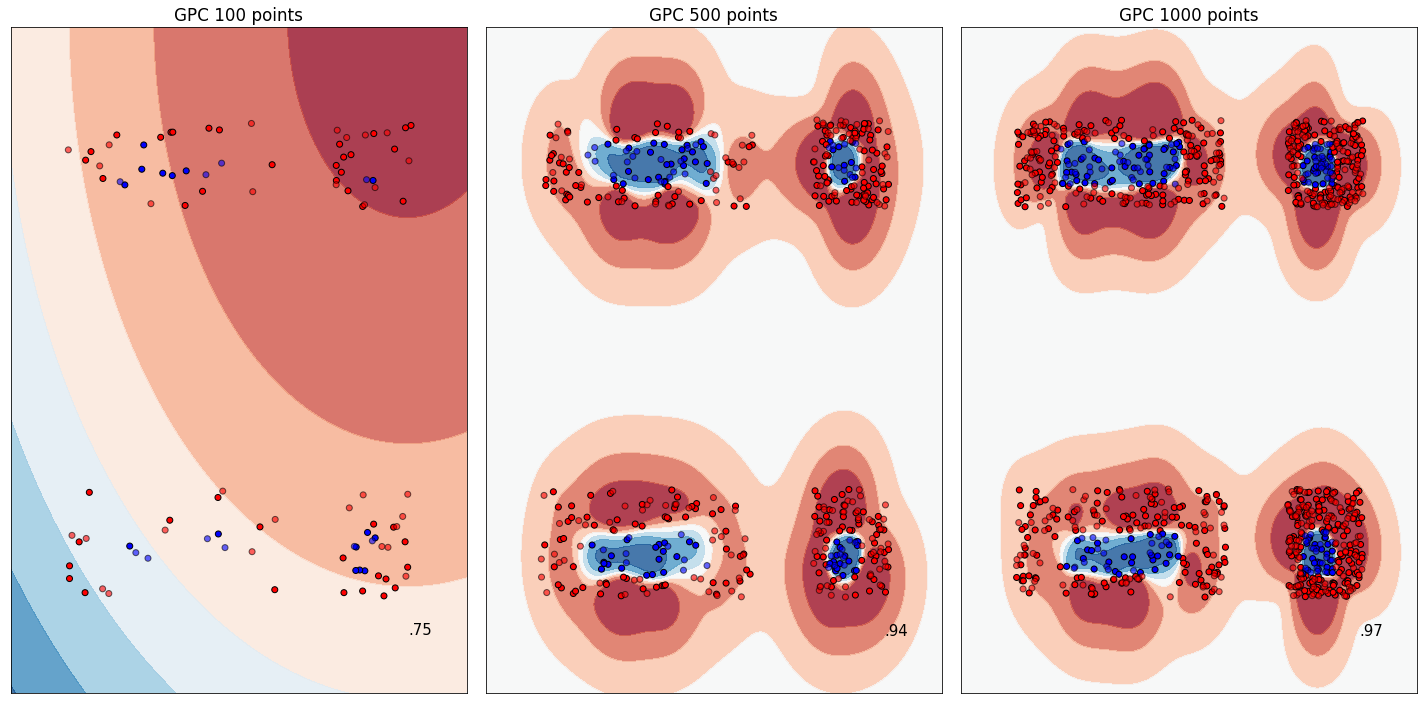

In [6]:
figure = plt.figure(figsize=(20, 10))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
     # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
#     ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
#     ax = plt.subplot(3,1,i)
#     
#     if ds_cnt == 0:
#         ax.set_title("Input data")
    # Plot the training points
#     ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
#                edgecolors='k')
#     # Plot the testing points
#     ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
#                edgecolors='k')
#     ax.set_xlim(xx.min(), xx.max())
#     ax.set_ylim(yy.min(), yy.max())
#     ax.set_xticks(())
#     ax.set_yticks(())
#     i += 1
    names = ["GPC 100 points", "GPC 500 points", "GPC 1000 points"]
    name = names[i-1]
#     clf = GaussianProcessClassifier(1.0 * RBF(1.0))
    clf = GaussianProcessClassifier(0.5 * RBF(0.5))
    
#     ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    ax = plt.subplot(1,len(datasets),i)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
               edgecolors='k', alpha=0.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
#     if ds_cnt == 0:
#         ax.set_title(name)
    ax.set_title(name)
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
            size=15, horizontalalignment='right')
    i += 1
plt.tight_layout()
plt.show()